In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-e6a5yso3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-e6a5yso3
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=a00b0cc67e86a998cce34ba2248ae9b361e00d952cc7b07bf6cf930dd9f40453
  Stored in directory: /tmp/pip-ephem-wheel-cache-0b2ra59b/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
# Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
# Download dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePI83CF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePI83CF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 # changes classes from 1, 2, 3 to 0, 1, 2
  return input_image, input_mask

In [6]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

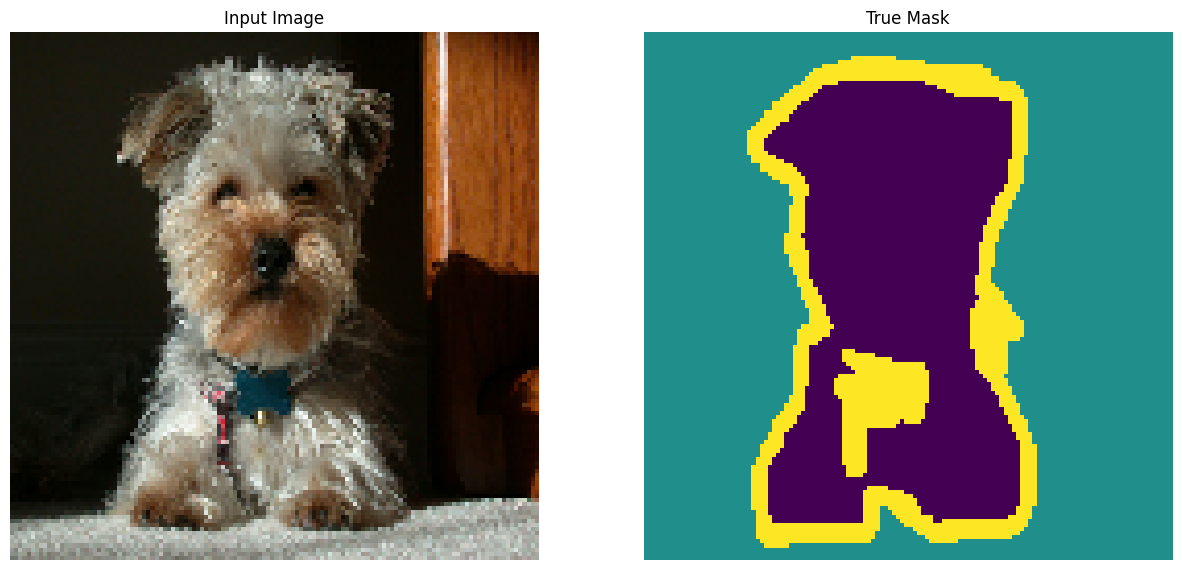

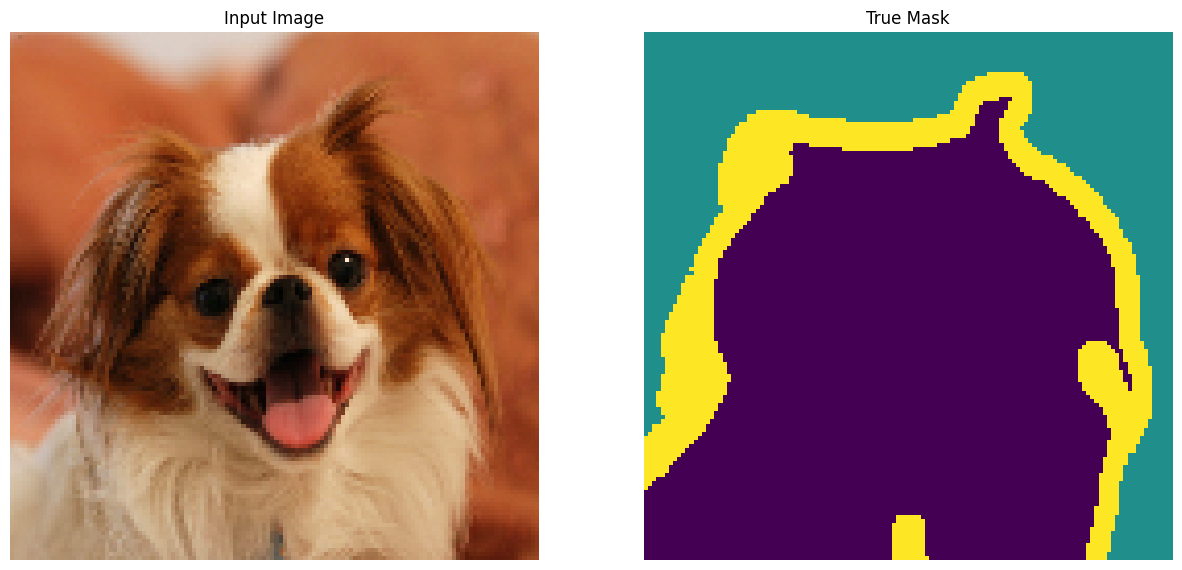

In [12]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [16]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

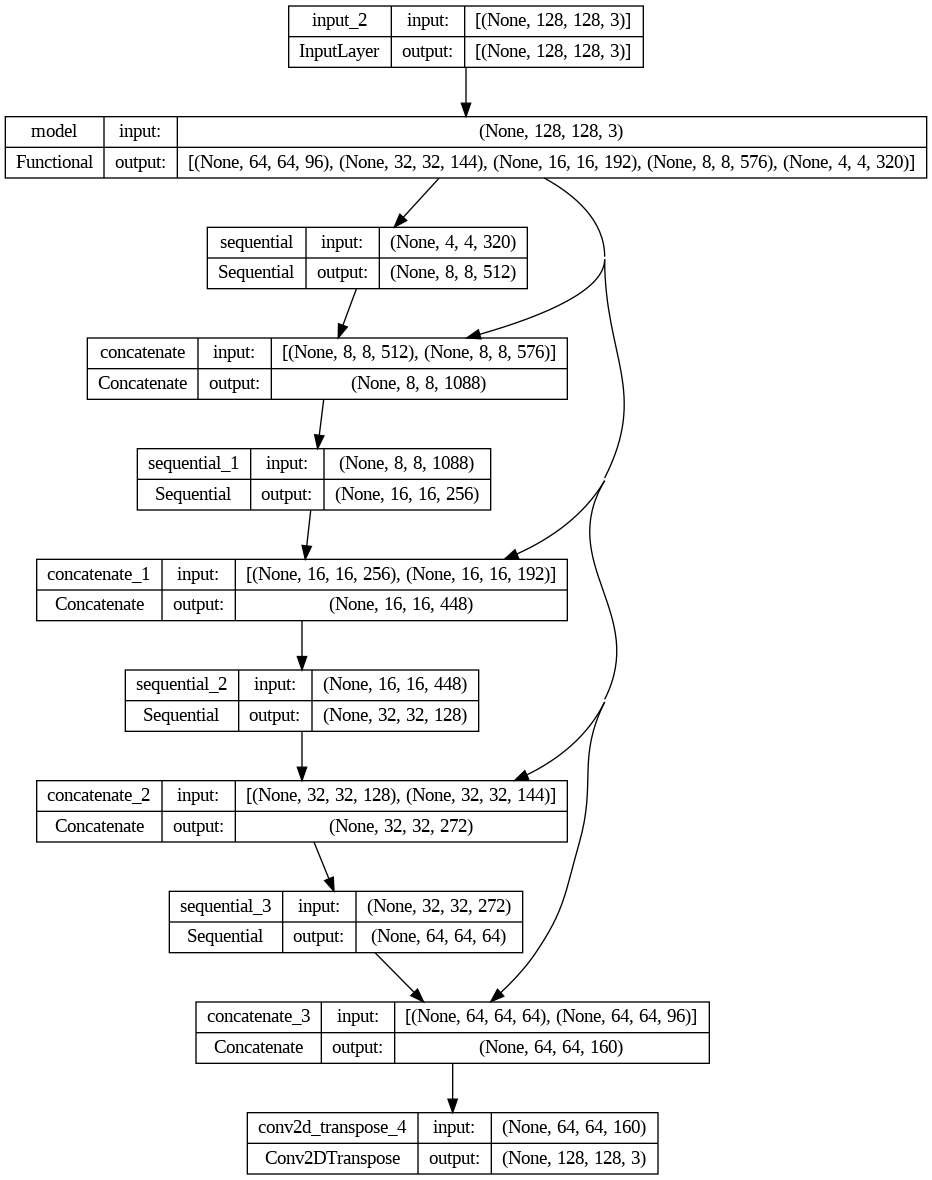

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [40]:
for image, mask in train_batches.take(1):
      pred_mask = model.predict(image)



2/2 [==============================] - 3s 1s/step


In [41]:
pred_mask[0]

array([[[-2.1433256 ,  1.4084779 , -0.55434096],
        [-3.7942872 ,  2.4182096 , -1.5385907 ],
        [-2.682483  ,  3.2275324 , -1.0841262 ],
        ...,
        [-3.3779452 ,  2.1948645 , -2.0145864 ],
        [-3.2425306 ,  2.7342608 , -1.6428232 ],
        [-3.162942  ,  1.4239248 , -1.7609115 ]],

       [[-3.4539683 ,  2.526271  , -0.9438507 ],
        [-2.4929008 ,  5.2773767 , -1.1584307 ],
        [-3.395982  ,  4.786526  , -2.1149237 ],
        ...,
        [-1.674443  ,  5.5386286 , -1.0392863 ],
        [-3.5332062 ,  4.247639  , -1.7853202 ],
        [-0.6365302 ,  5.195383  ,  0.27209756]],

       [[-3.2867274 ,  1.6066033 , -2.8713021 ],
        [-3.4172688 ,  4.398065  , -2.3029633 ],
        [-4.1756306 ,  2.908851  , -3.7996778 ],
        ...,
        [-3.6610124 ,  3.8470364 , -3.125914  ],
        [-5.044468  ,  1.8794781 , -4.332418  ],
        [-3.1172166 ,  3.6804216 , -1.5511097 ]],

       ...,

       [[-2.3232696 ,  1.7654884 , -1.1742055 ],
        [-1

In [42]:
pred_mask = tf.math.argmax(pred_mask[0], axis=-1)
pred_mask

<tf.Tensor: shape=(128, 128), dtype=int64, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>

In [43]:
pred_mask = pred_mask[..., tf.newaxis]
pred_mask

<tf.Tensor: shape=(128, 128, 1), dtype=int64, numpy=
array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]])>

In [29]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


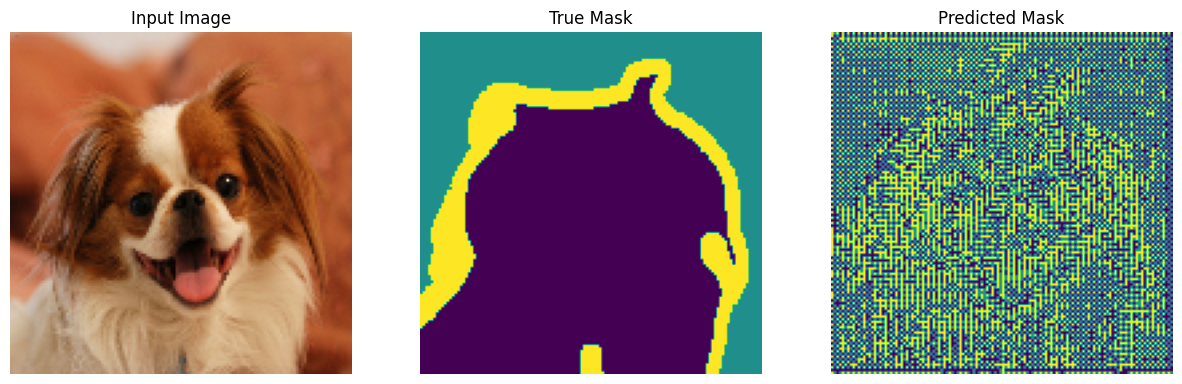

In [20]:
show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 90ms/step


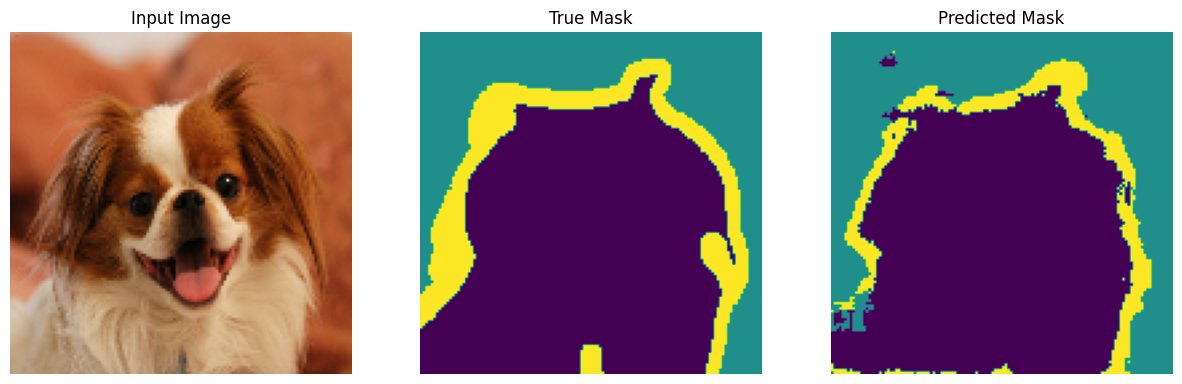


Sample Prediction after epoch 2

57/57 [==============================] - 478s 8s/step - loss: 0.2551 - accuracy: 0.9009 - val_loss: 0.2679 - val_accuracy: 0.8993


In [24]:
EPOCHS = 2
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

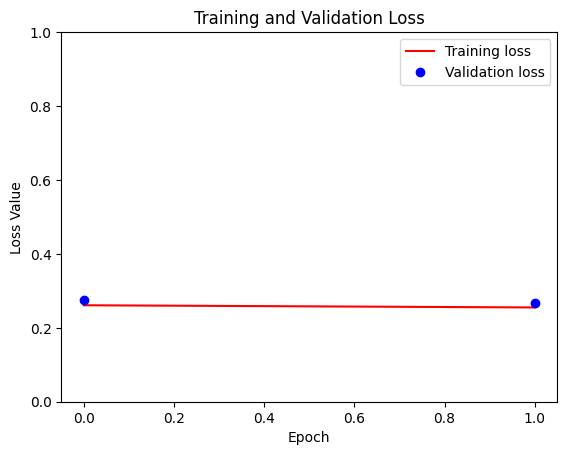

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 5s 3s/step


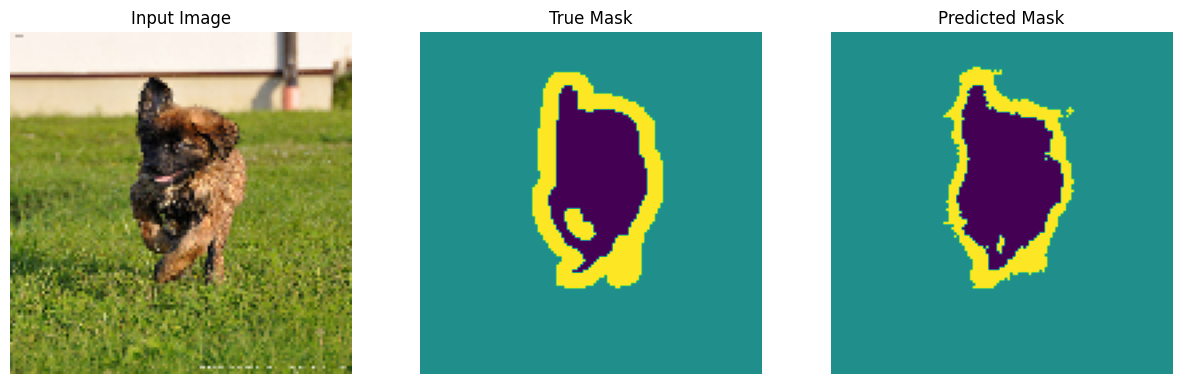

2/2 [==============================] - 4s 2s/step


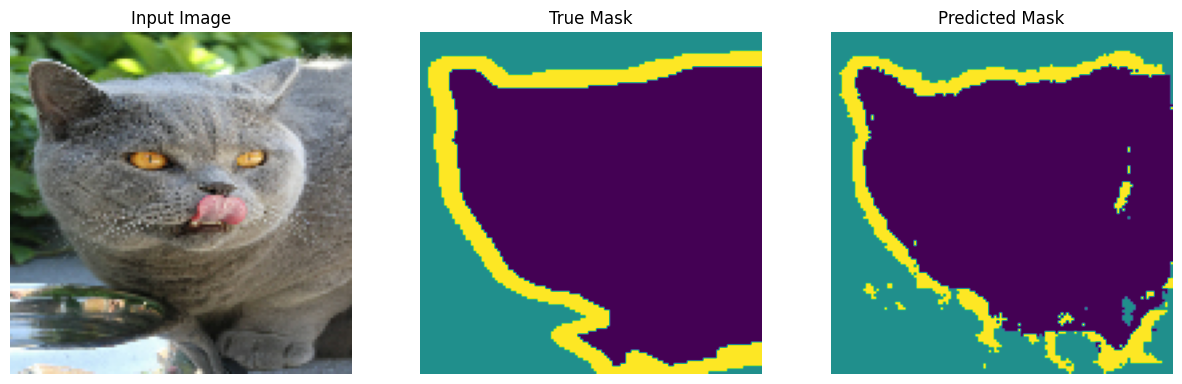

2/2 [==============================] - 5s 2s/step


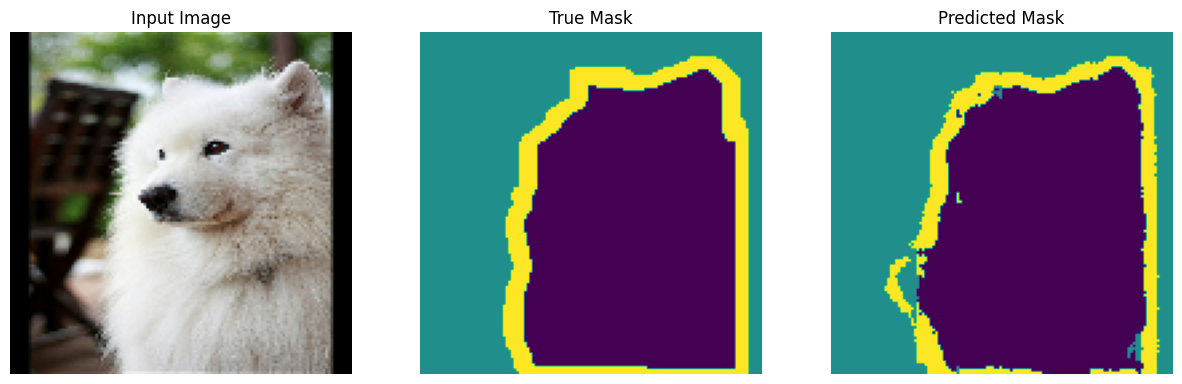

In [28]:
show_predictions(test_batches, 3)